# Introduction

# Libraries and Modules

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil
import cv2
import pytesseract
from PIL import Image
from scipy import ndimage
import swifter
from IPython.display import Image
import pydotplus
import pickle

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
# import tensorflow as tf
# from keras import Model
# from keras.applications.resnet50 import ResNet50
# from keras.preprocessing import image
# from keras.applications.resnet50 import preprocess_input, decode_predictions
# from keras.layers import GlobalMaxPooling2D
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from sklearn.metrics.pairwise import pairwise_distances
# from keras import models

## Py files

In [1]:
import preprocess as pre
# import images
import recommendation as reco
%reload_ext autoreload
%autoreload 2

In [5]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


# Pre-processing

In [3]:
pets = pd.read_csv("pets.csv")
pets.dropna(axis=0, subset=["filename"], inplace=True)
pets = pre.drop_columns(pets, ["adoption_speed"])
pets.isna().sum()

pet_id                      0    
type                        0    
name                        1197 
age                         0    
breed1                      0    
breed1_desc                 4    
breed2                      0    
breed2_desc                 10519
gender                      0    
color1                      0    
color1_desc                 0    
color2                      0    
color2_desc                 4340 
color3                      0    
color3_desc                 10376
maturity_size               0    
fur_length                  0    
vaccinated                  0    
dewormed                    0    
sterilized                  0    
health                      0    
quantity                    0    
fee                         0    
state                       0    
state_desc                  0    
rescuer_id                  0    
video_count                 0    
photo_count                 0    
filename                    0    
description   

In [4]:
pets.fillna("", inplace=True)
pets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14652 entries, 0 to 14992
Data columns (total 34 columns):
pet_id                      14652 non-null object
type                        14652 non-null int64
name                        14652 non-null object
age                         14652 non-null int64
breed1                      14652 non-null int64
breed1_desc                 14652 non-null object
breed2                      14652 non-null int64
breed2_desc                 14652 non-null object
gender                      14652 non-null int64
color1                      14652 non-null int64
color1_desc                 14652 non-null object
color2                      14652 non-null int64
color2_desc                 14652 non-null object
color3                      14652 non-null int64
color3_desc                 14652 non-null object
maturity_size               14652 non-null int64
fur_length                  14652 non-null int64
vaccinated                  14652 non-null int64
de

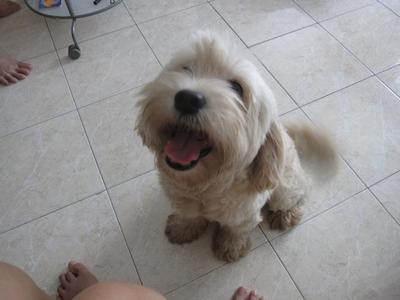

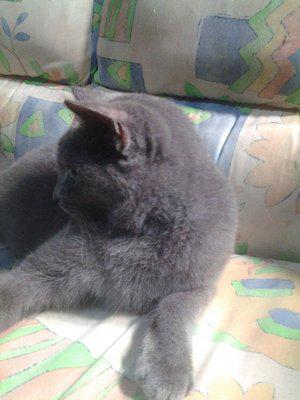

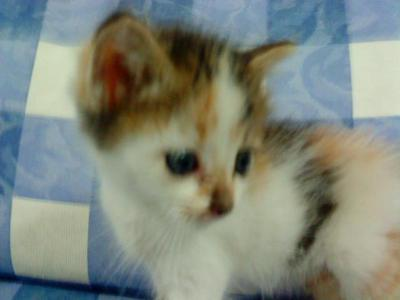

In [34]:
images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
for i in range(3):
    j = list(pets.index)[np.random.randint(low=0, high=pets.shape[0])]
    pre.get_image(images_folder_path, pets.filename[j])

In [5]:
dogs = pets.query("type==1")
cats = pets.query("type==2")

# pickle.dump(dogs, open("df_dogs.pkl", "wb"))
# pickle.dump(cats, open("df_cats.pkl", "wb"))

# Resnet50

In [24]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([base_model, GlobalMaxPooling2D()])
model.summary()
# pickle.dump(model, open("image_reco.pkl", "wb"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [43]:
i = np.random.randint(low=0, high=pets.shape[0])
display(images.get_embedding(model, pets.filename.loc[i],images_folder_path))

In [45]:
plt.imshow(cv2.cvtColor(images.load_image(pets, i, images_folder_path), cv2.COLOR_BGR2RGB));

In [ ]:
map_embeddings_dogs = dogs.filename.swifter.apply(lambda img: get_embedding(model, img,images_folder_path))
data_embs_dogs = map_embeddings_dogs.apply(pd.Series)
map_embeddings_cats = cats.filename.swifter.apply(lambda img: get_embedding(model, img,images_folder_path))
data_embs_cats = map_embeddings_cats.apply(pd.Series)

In [ ]:
to_include = ["type", "gender", "breed1", "breed2", "color1", "color2", "color3", "state"]
df_data_embs_dogs = pd.concat([data_embs_dogs, dogs[to_include]], axis=1)
df_data_embs_cats = pd.concat([data_embs_cats, cats[to_include]], axis=1)
df_cosine_dogs = 1-pairwise_distances(df_data_embs_dogs, metric='cosine')
df_cosine_cats = 1-pairwise_distances(df_data_embs_cats, metric='cosine')
# pickle.dump(df_cosine_dogs, open("df_cosine_dogs.pkl", "wb"))
# pickle.dump(df_cosine_cats, open("df_cosine_cats.pkl", "wb"))

# Test Model

In [91]:
# random = np.random.randint(low=0, high=len(pets))
# reco.get_reco(list(pets.index)[random], pets, 2)

In [8]:
interact(reco.get_reco,
         i=widgets.IntSlider(min=0, max=len(pets), step=1),
         df=fixed(pets),
         top=widgets.IntSlider(min=1, max=4, step=1, value=2))

interactive(children=(IntSlider(value=0, description='i', max=14652), IntSlider(value=2, description='top', ma…

<function recommendation.get_reco(i, df, top=2)>

In [18]:
caption = widgets.Label(value="Select the pet to view:")
idx, top = widgets.IntSlider(min=0,
                             max=len(pets),
                             step=1,
                             value=4,
                             description='Index'), widgets.IntSlider(
                                 min=1,
                                 max=4,
                                 step=1,
                                 value=2,
                                 description='Top')
dl = widgets.dlink((idx, 'value'), (top, 'value'))
display(caption)
interact(reco.get_reco, i=idx, df=fixed(pets), top=top)

Label(value='Select the pet to view:')

interactive(children=(IntSlider(value=4, description='Index', max=14652), IntSlider(value=4, description='Top'…

<function recommendation.get_reco(i, df, top=2)>